In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy.interpolate import make_interp_spline

In [2]:
def EE(yn, f, tau, t=0):
    return yn + tau*f(yn,t)

def RK4(yn, f, tau, t=0):
    k1=f(yn,t)
    k2=f(yn+tau*k1/2,t)
    k3=f(yn+tau*k2/2,t)
    k4=f(yn+tau*k3,t)
    return yn+tau/6*(k1+2*k2+2*k3+k4)

def gauss_legendre2(f, y0, t_span, tau):
    c=np.array([0.5 - np.sqrt(3)/6, 0.5 + np.sqrt(3)/6])
    b=np.array([0.5, 0.5])
    A=np.array([
    [0.25, 0.25 - np.sqrt(3)/6],
    [0.25 + np.sqrt(3)/6, 0.25]])

    t0, tf=t_span
    ts=[t0]
    ys=[y0]
    t=t0
    y=y0

    kozos_t=[t0]
    kozos_y=[y0]

    while t < tf:
        tau = min(tau, tf - t)  # Final step size adjustment
        def F(K):
            K=K.reshape(2, -1)
            eqs=[]
            for i in range(2):
                ti=t+c[i]*tau
                yi=y+tau*(A[i, 0]*K[0]+A[i, 1]*K[1])
                eqs.append(K[i]-f(ti, yi))
            return np.concatenate(eqs)
        K0=np.tile(f(t, y), (2, 1)).flatten()
        kozos_t.append(t+tau*c[0])
        kozos_t.append(t+tau*c[1])
        K_sol=fsolve(F, K0).reshape(2, -1)
        kozos_y.append(y+tau*np.dot(A[0,:],K_sol))
        kozos_y.append(y+tau*np.dot(A[1,:],K_sol))
        y=y+tau*np.dot(b, K_sol)
        t=t+tau
        kozos_t.append(t)
        kozos_y.append(y)
        ts.append(t)
        ys.append(y)

    return np.array(ts), np.array(ys), np.array(kozos_t), kozos_y

def radau2(f, y0, t_span, tau):
    c=np.array([1/3, 1])
    b=np.array([3/4, 1/4])
    A=np.array([
    [5/12, -1/12],
    [3/4, 1/4]])

    t0, tf=t_span
    t=t0
    y=y0
    ts=[t0]
    ys=[y0]

    kozos_t=[t0]
    kozos_y=[y0]

    while t < tf:
        tau=min(tau, tf-t)
        def F(K):
            K=K.reshape(2, -1)
            eqs=[]
            for i in range(2):
                ti=t+c[i]*tau
                yi=y+tau*(A[i, 0]*K[0]+A[i, 1]*K[1])
                eqs.append(K[i]-f(ti, yi))
            return np.concatenate(eqs)
        K0=np.tile(f(t, y), (2, 1)).flatten()
        kozos_t.append(t+tau*c[0])
        kozos_t.append(t+tau*c[1])
        K_sol=fsolve(F, K0).reshape(2, -1)
        kozos_y.append(y+tau*np.dot(A[0,:],K_sol))
        kozos_y.append(y+tau*np.dot(A[1,:],K_sol))
        y=y+tau*np.dot(b, K_sol)
        t=t+tau
        kozos_t.append(t)
        kozos_y.append(y)
        ts.append(t)
        ys.append(y)

    return np.array(ts), np.array(ys), np.array(kozos_t), kozos_y

def imp_trapez(f, y0, t_span, tau):
    c=np.array([0, 1])
    b=np.array([1/2, 1/2])
    A=np.array([
    [0, 0],
    [1/2, 1/2]])

    t0, tf=t_span
    t=t0
    y=y0
    ts=[t0]
    ys=[y0]

    while t < tf:
        tau=min(tau, tf-t)
        def F(K):
            K=K.reshape(2, -1)
            eqs=[]
            for i in range(2):
                ti=t+c[i]*tau
                yi=y+tau*(A[i, 0]*K[0]+A[i, 1]*K[1])
                eqs.append(K[i]-f(ti, yi))
            return np.concatenate(eqs)
        K0=np.tile(f(t, y), (2, 1)).flatten()
        K_sol=fsolve(F, K0).reshape(2, -1)
        y=y+tau*np.dot(b, K_sol)
        t=t+tau
        ts.append(t)
        ys.append(y)

    return np.array(ts), np.array(ys)

def imp_euler(f, y0, t_span, tau):
    t0, tf = t_span
    t=t0
    y=np.array(y0, dtype=float)  
    ts=[t0]
    ys=[y.copy()]

    while t < tf:
        tau=min(tau, tf - t)
        def F(K):
            K=np.array(K)
            return K-f(t+tau, y+tau*K)
        K0 = f(t, y)
        K_sol=fsolve(F, K0)
        y=y+tau*K_sol
        t=t+tau
        ts.append(t)
        ys.append(y.copy())

    return np.array(ts), np.array(ys)

## 1. példa: Harmonikus rezgőmozgás

$$ x''(t)=-\omega^2x(t)$$

$$\begin{cases}
x'(t)=v(t) \\
v'(t)=-\omega^2x(t)
\end{cases}$$

Legyen $\omega=1$

In [4]:
def harmonikus(y,t):
    return  np.array([y[1],-y[0]])

def IE_harmonikus(y, tau):
    x=y[0]/(1+tau**2)+tau*y[1]/(1+tau**2)
    v=(1-tau**2/(1+tau**2))*y[1]-tau*y[0]/(1+tau**2)
    return np.array([x,v])

def trapez_harmonikus(y, tau):
    x=y[0]*(1-tau**2/4)/(1+tau**2/4)+y[1]*(tau/(1+tau**2/4))
    v=y[1]-y[0]*tau/2-x*tau/2
    return np.array([x,v])

In [4]:
tau=0.1
T=20
lepszam=int(np.ceil(T/tau))
t_ertekek=[i*tau for i in range(lepszam)]
yEE=np.zeros((2,lepszam))
yIE=np.zeros((2,lepszam))
yTR=np.zeros((2,lepszam))
yEE[:,0], yIE[:,0], yTR[:,0] = [1,0], [1,0], [1,0]

for i in range(1,lepszam):
    yEE[:,i]=EE(yEE[:,i-1],harmonikus,tau)
    yIE[:,i]=IE_harmonikus(yIE[:,i-1],tau)
    yTR[:,i]=trapez_harmonikus(yTR[:,i-1],tau)
x=0
y=0
r=1
theta=np.linspace(0,2*np.pi, 500)
x = x + r * np.cos(theta)
y = y + r * np.sin(theta)

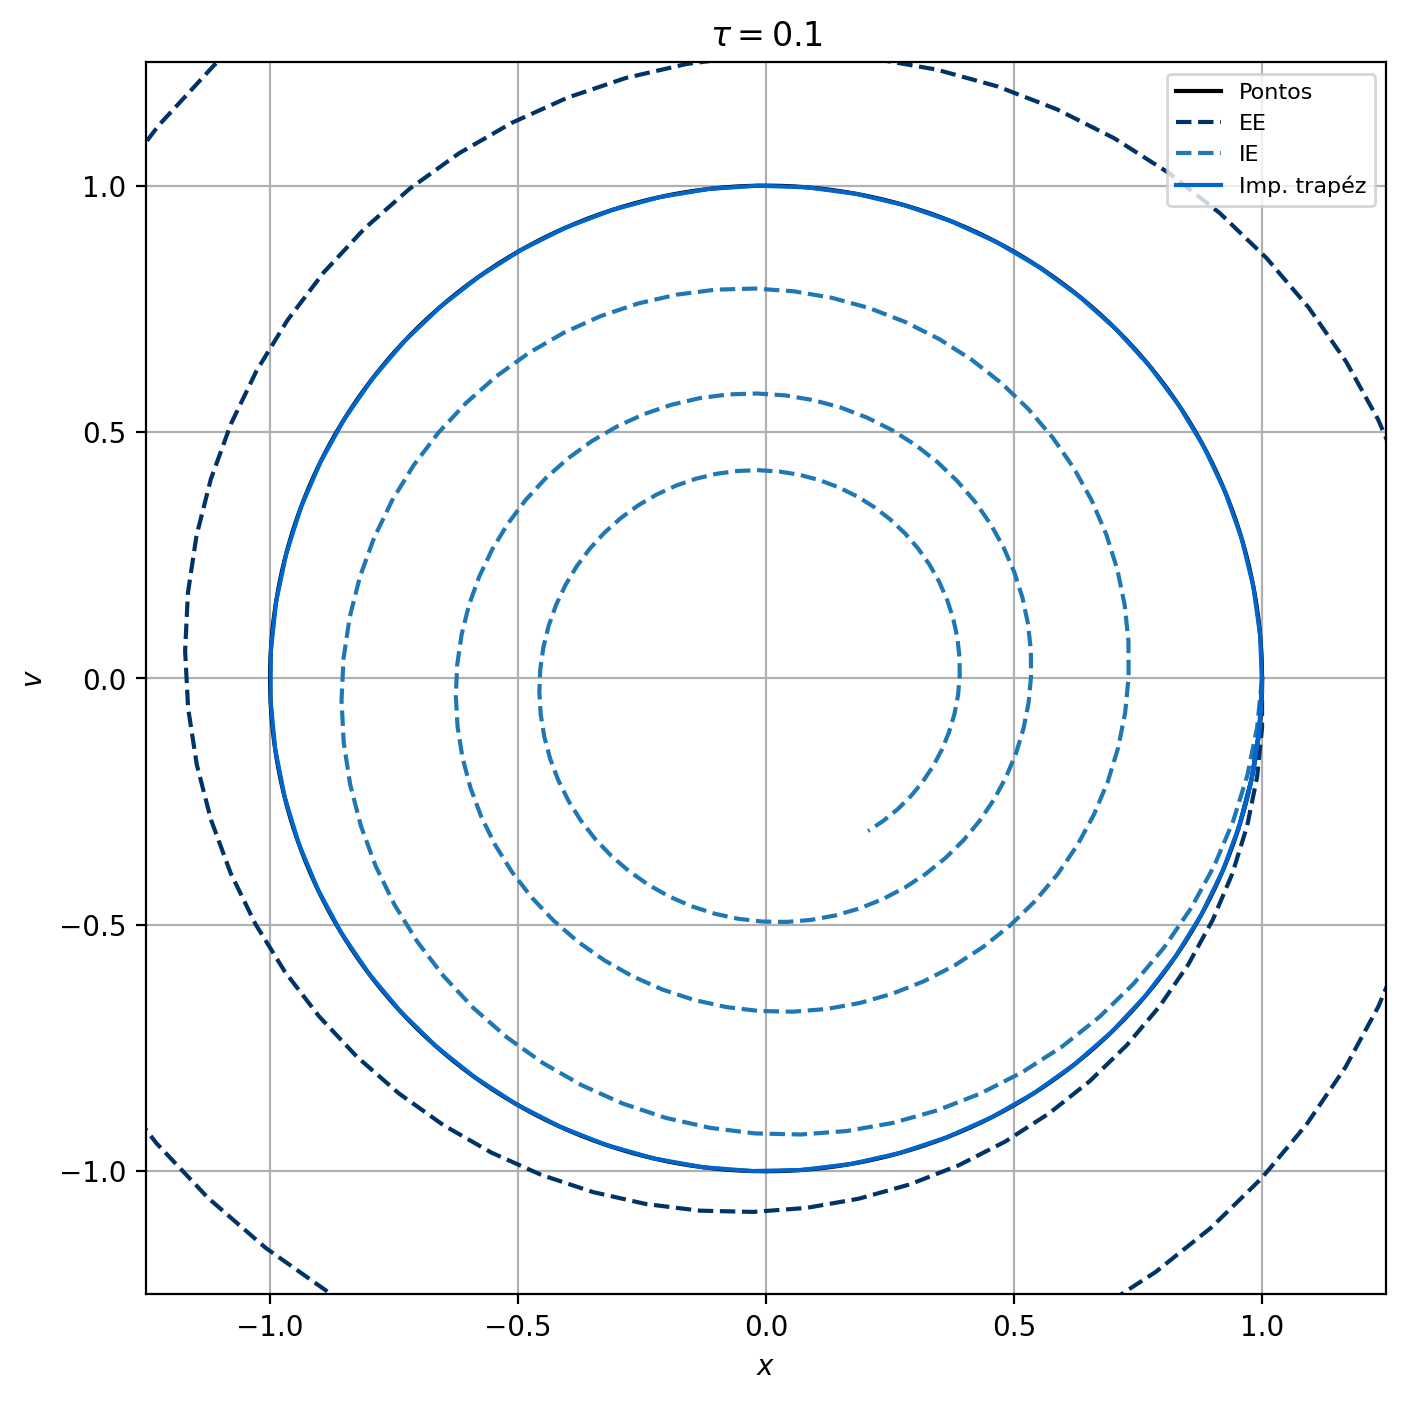

In [5]:
fig, ax = plt.subplots(figsize=(8,8), dpi=200)
a=1.25
plt.plot(x,y, color="black", label="Pontos", alpha=1)
plt.plot(yEE[0,:],yEE[1,:], color="#003366", linestyle="--", label="EE")
plt.plot(yIE[0,:],yIE[1,:], linestyle="--", label="IE")
plt.plot(yTR[0,:int(np.ceil(T/(3*tau)))],yTR[1,:int(np.ceil(T/(3*tau)))], color="#0066CC", label="Imp. trapéz")
plt.title(r"$\tau=$"+f"{tau}")
plt.legend(fontsize=8,loc="upper right")
plt.xlabel(r"$x$")
plt.ylabel(r"$v$")
plt.grid(True)
plt.xlim(-a,a)
plt.ylim(-a,a)

plt.show()


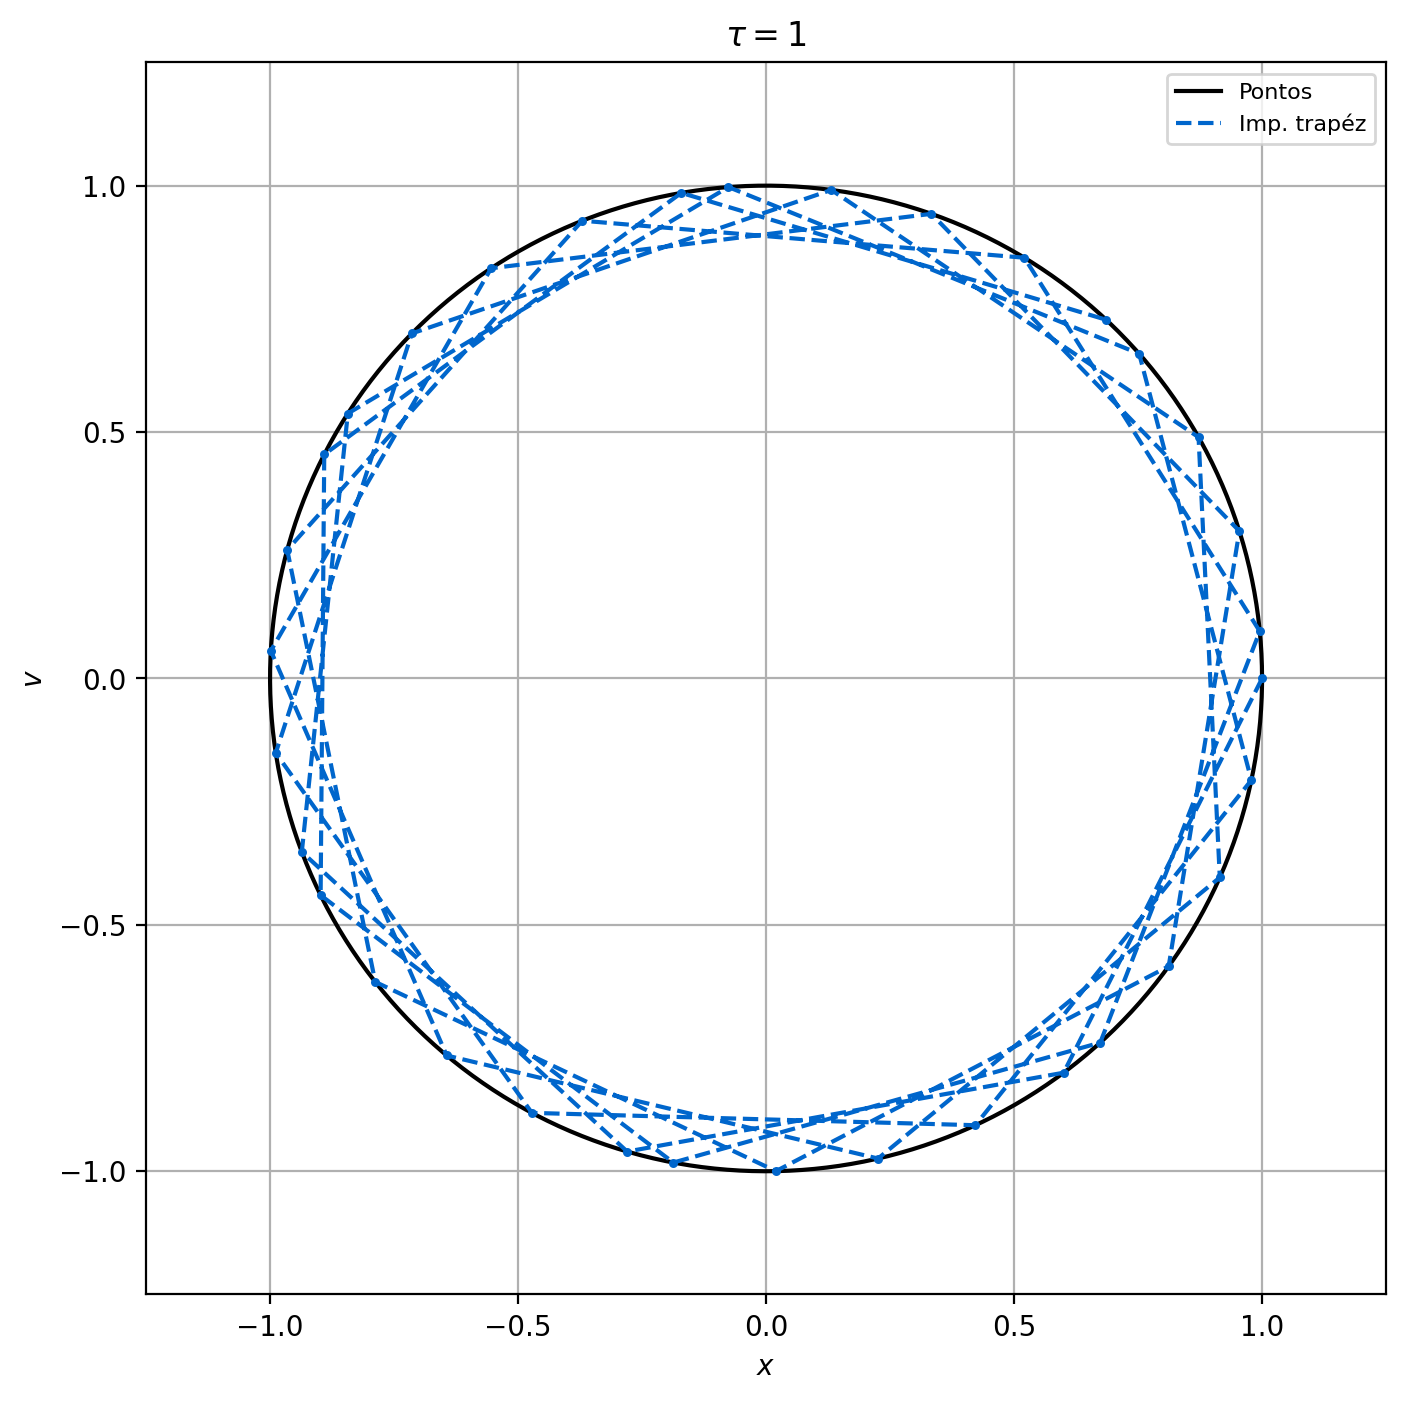

In [182]:
tau=1
T=100
lepszam=int(np.ceil(T/tau))
t_ertekek=[i*tau for i in range(lepszam)]
yTR=np.zeros((2,lepszam))
yTR[:,0] = [1,0]

for i in range(1,lepszam):
    yTR[:,i]=trapez_harmonikus(yTR[:,i-1],tau)
x=0
y=0
r=1
theta=np.linspace(0,2*np.pi, 500)
x = x + r * np.cos(theta)
y = y + r * np.sin(theta)

fig, ax = plt.subplots(figsize=(8,8), dpi=200)
a=1.25
plt.plot(x,y, color="black", label="Pontos", alpha=1)
plt.plot(yTR[0,:int(np.ceil(T/(3*tau)))],yTR[1,:int(np.ceil(T/(3*tau)))], color="#0066CC", linestyle="--", label="Imp. trapéz")
plt.scatter(yTR[0,:int(np.ceil(T/(3*tau)))],yTR[1,:int(np.ceil(T/(3*tau)))], color="#0066CC", s=5, zorder=2)
plt.title(r"$\tau=$"+f"{tau}")
plt.legend(fontsize=8,loc="upper right")
plt.xlabel(r"$x$")
plt.ylabel(r"$v$")
plt.grid(True)
plt.xlim(-a,a)
plt.ylim(-a,a)

plt.show()

## 2. példa: Prothero-Robinson egyenlet

$$\begin{cases}
y'(t)=\lambda(y(t)-\varphi(t))+\varphi'(t) \\
y_0=\varphi(t_0)
\end{cases}$$
$$\varphi(t)=\arctan(2t)$$

In [6]:
def phi(t):
    return np.arctan(2*t)

def dphi(t):
    return 2/(4*t**2+1)

def hairer(y,t):
    lamb=1
    return lamb*(y-phi(t))+dphi(t)

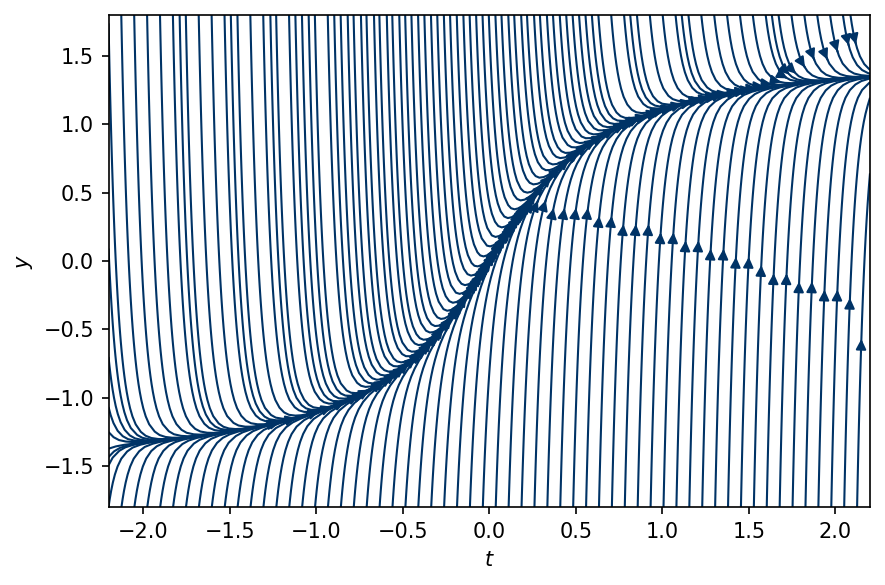

In [7]:
x_max=2.2
y_max=1.8
t = np.linspace(-x_max, x_max, 250)
y = np.linspace(-y_max, y_max, 250)
T, Y = np.meshgrid(t, y)

lamb=-20

x1 = np.ones_like(T)
x2 = lamb*(Y-phi(T))+dphi(T)

fig, ax = plt.subplots(figsize=(6,4), dpi=150)
plt.streamplot(T,Y,x1,x2, color="#003366", linewidth=1, density=2, broken_streamlines=False)
#plt.plot(t,phi(t), color="black")
plt.xlabel(r"$t$")
plt.ylabel(r"$y$")
plt.xlim(-x_max,x_max)
plt.ylim(-y_max,y_max)
#ax.set_aspect("equal")
plt.tight_layout()
plt.show()

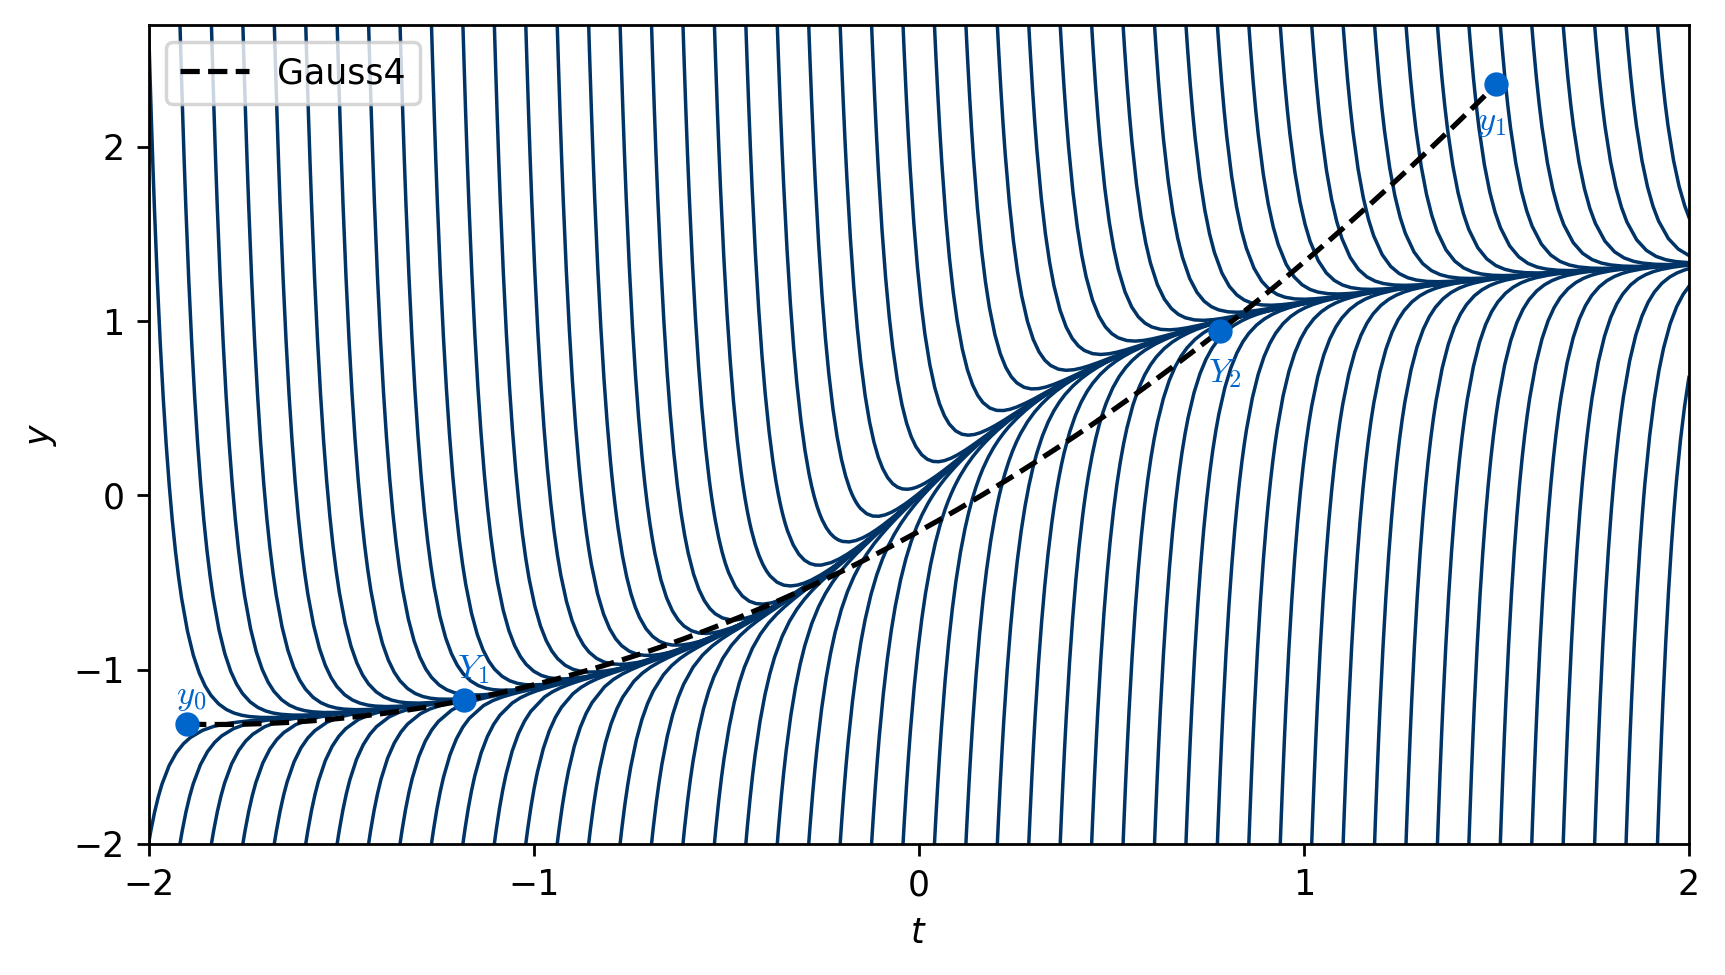

In [8]:
rcParams['axes.xmargin']=0
rcParams['axes.ymargin']=0

def ivp_robinson(t,y):
    return -20*(y-phi(t))+dphi(t)

lamb=-20
IV=[2.7, -2]
t_plus=np.linspace(0,4,50)
fig, ax = plt.subplots(figsize=(7,4), dpi=250)
for t in t_plus:
    for iv in IV:
        y_0=iv
        sol=solve_ivp(ivp_robinson, [-2+t,2], [y_0], method="BDF")
        plt.plot(sol.t, sol.y[0], color="#003366", linewidth=1)

ts, ys, kt, ky=gauss_legendre2(ivp_robinson,np.array([phi(-1.9)]),(-1.9,1.5),3.4)

koord=np.array([[kt[i],ky[i][0]] for i in range(len(kt))])
x=koord[:,0]
y=koord[:,1]
x_smooth = np.linspace(x.min(), x.max(), 200)
spline = make_interp_spline(x, y, k=3)
y_smooth=spline(x_smooth)
plt.plot(x_smooth, y_smooth, 'k--', label='Gauss4')
plt.scatter(kt, ky, color="#0066CC", zorder=2)
with plt.rc_context({'mathtext.fontset': 'cm'}):
    plt.text(-1.93,-1.2,r"$y_0$", color="#0066CC")
    plt.text(-1.2,-1.05,r"$Y_1$", color="#0066CC")
    plt.text(0.75,0.65,r"$Y_2$", color="#0066CC")
    plt.text(1.45,2.1,r"$y_1$", color="#0066CC")
plt.xticks([-2+i for i in range(5)])
plt.yticks([-2+i for i in range(5)])
plt.xlabel(r"$t$")
plt.ylabel(r"$y$")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

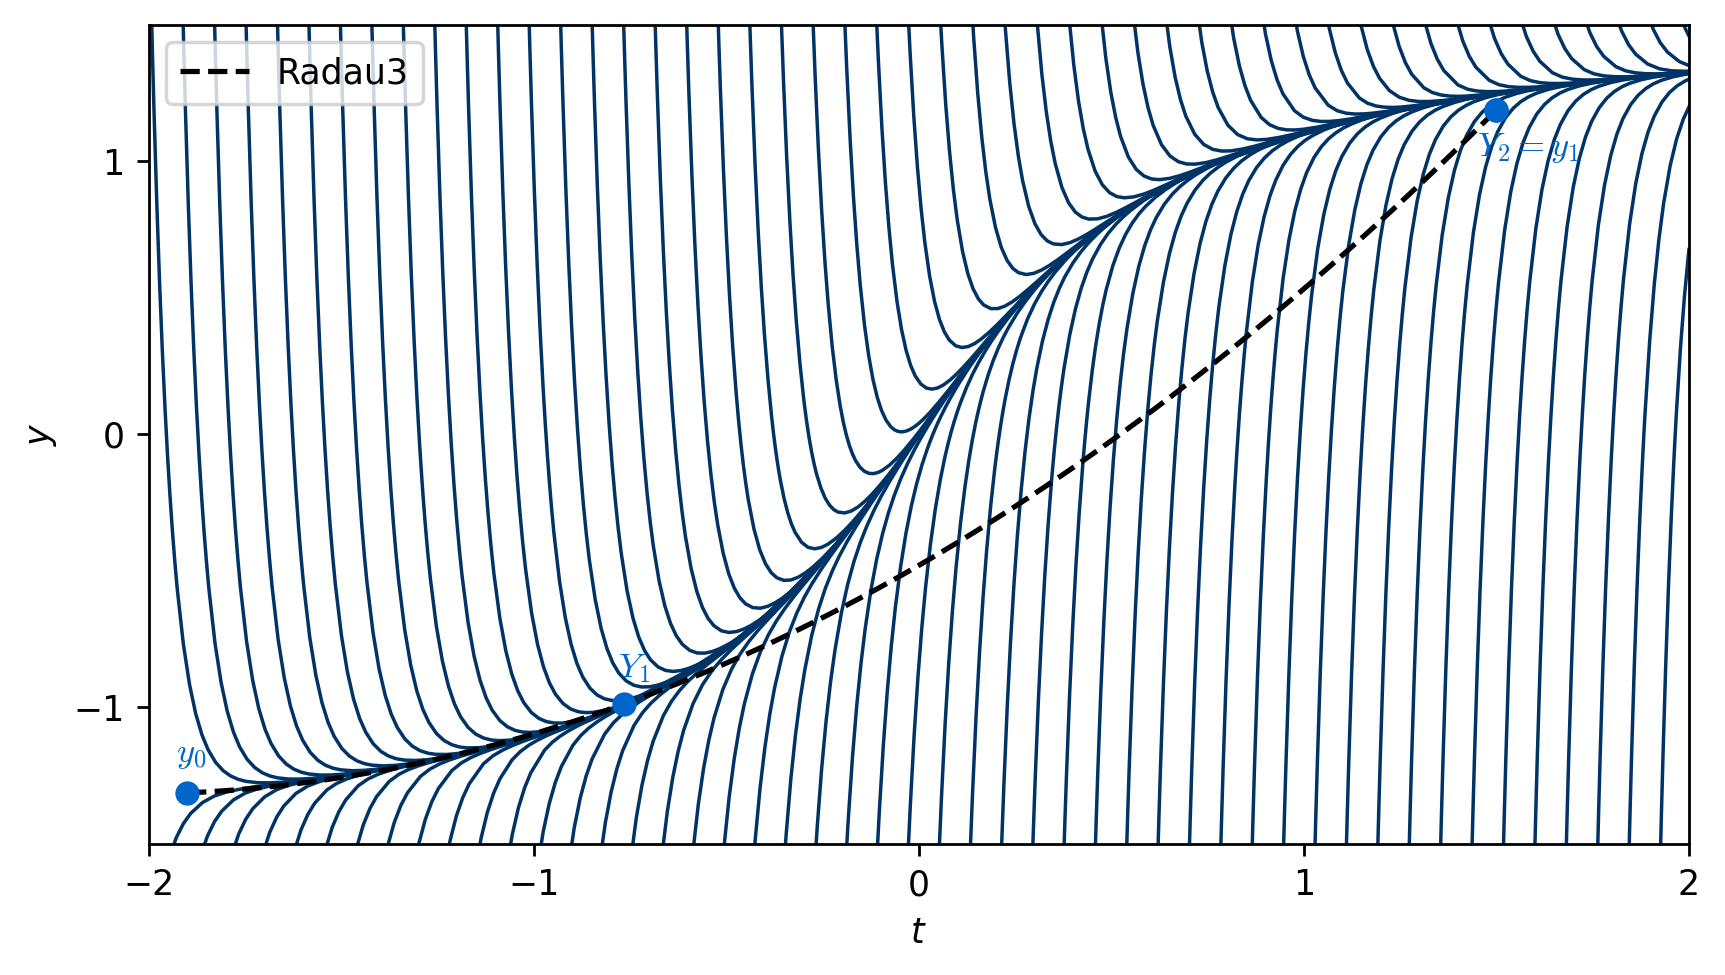

In [9]:
rcParams['axes.xmargin']=0
rcParams['axes.ymargin']=0

def ivp_robinson(t,y):
    return -20*(y-phi(t))+dphi(t)

lamb=-20
IV=[2, -2]
t_plus=np.linspace(0,4,50)
fig, ax = plt.subplots(figsize=(7,4), dpi=250)
for t in t_plus:
    for iv in IV:
        y_0=iv
        sol=solve_ivp(ivp_robinson, [-2+t,2], [y_0], method="BDF")
        plt.plot(sol.t, sol.y[0], color="#003366", linewidth=1)

ts, ys, kt, ky=radau2(ivp_robinson,np.array([phi(-1.9)]),(-1.9,1.5),3.4)

koord=np.array([[kt[i],ky[i][0]] for i in range(len(kt)-1)])
x=koord[:,0]
y=koord[:,1]
x_smooth = np.linspace(x.min(), x.max(), 200)
spline = make_interp_spline(x, y, k=2)
y_smooth=spline(x_smooth)
plt.plot(x_smooth, y_smooth, 'k--', label='Radau3')
plt.scatter(kt, ky, color="#0066CC", zorder=2)
with plt.rc_context({'mathtext.fontset': 'cm'}):
    plt.text(-1.93,-1.2,r"$y_0$", color="#0066CC")
    plt.text(-0.78,-0.89,r"$Y_1$", color="#0066CC")
    plt.text(1.45,1.02,r"$Y_2=y_{1}$", color="#0066CC")
plt.xticks([-2+i for i in range(5)])
plt.yticks([-2+i for i in range(5)])
plt.ylim(-1.5,1.5)
plt.xlabel(r"$t$")
plt.ylabel(r"$y$")
plt.legend()
plt.tight_layout()
plt.show()

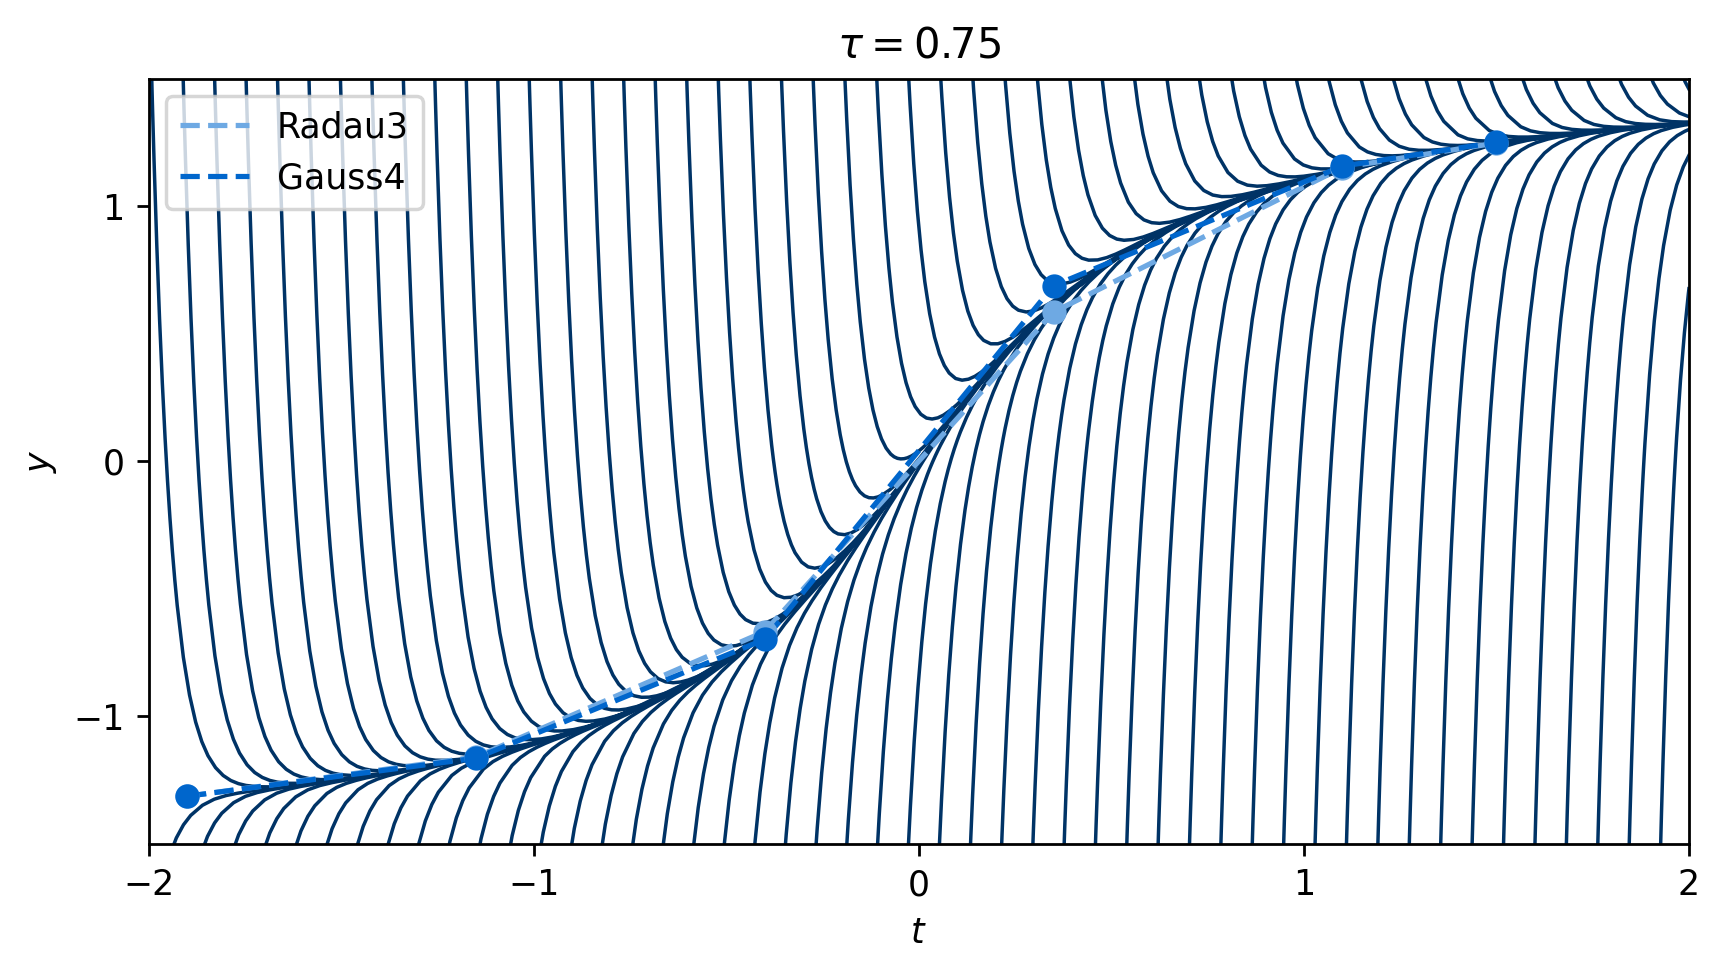

In [29]:
rcParams['axes.xmargin']=0
rcParams['axes.ymargin']=0

def ivp_robinson(t,y):
    return -20*(y-phi(t))+dphi(t)

lamb=-20
tau=0.75
IV=[2, -2]
t_plus=np.linspace(0,4,50)
fig, ax = plt.subplots(figsize=(7,4), dpi=250)
for t in t_plus:
    for iv in IV:
        y_0=iv
        sol=solve_ivp(ivp_robinson, [-2+t,2], [y_0], method="BDF")
        plt.plot(sol.t, sol.y[0], color="#003366", linewidth=1)

tr, yr, kt, ky=radau2(ivp_robinson,np.array([phi(-1.9)]),(-1.9,1.5),tau)
tg, yg, kt, ky=gauss_legendre2(ivp_robinson,np.array([phi(-1.9)]),(-1.9,1.5),tau)

plt.plot(tr,yr, linestyle="--", color="#6EA9E3", label="Radau3")
plt.plot(tg,yg, linestyle="--", color="#0066CC", label="Gauss4")

plt.scatter(tr,yr, color="#6EA9E3", zorder=2)
plt.scatter(tg,yg, color="#0066CC", zorder=2)

plt.xticks([-2+i for i in range(5)])
plt.yticks([-2+i for i in range(5)])
plt.ylim(-1.5,1.5)
plt.title(r"$\tau=$"+f"{tau}")
plt.xlabel(r"$t$")
plt.ylabel(r"$y$")
plt.legend()
plt.tight_layout()
plt.show()

## 3. példa: Lánggömb

$$\begin{cases}
y'(t)=y^2(t)-y^3(t) \\
y(0)=\delta
\end{cases}$$
$$t \in \left[0, \frac{2}{\delta}\right]$$

In [95]:
def langgomb(t,y):
    return y**2-y**3

def langgomb_RK4(y,t=0):
    return y**2-y**3

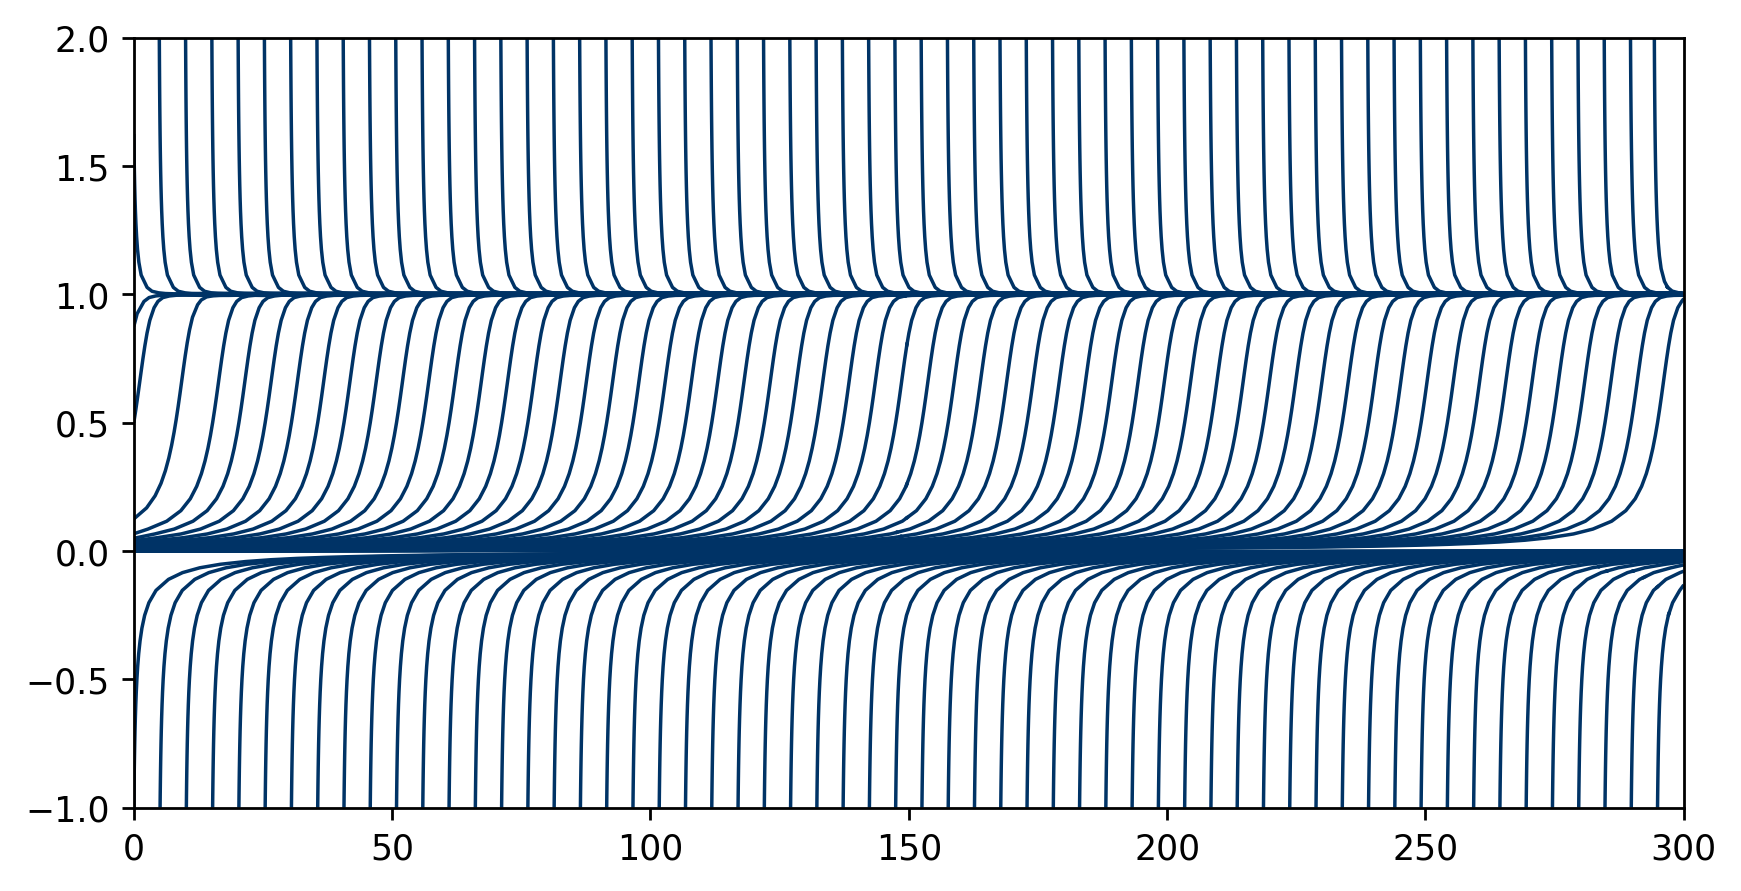

In [159]:
x_max=3/0.01
y_max=2
t = np.linspace(0, x_max, 250)
y = np.linspace(-1, y_max, 250)
Tt, Y = np.meshgrid(t, y)

x1 = np.ones_like(Tt)
x2 = Y**2-Y**3

fig, ax = plt.subplots(figsize=(8,4), dpi=250)
plt.streamplot(Tt,Y,x1,x2, color="#003366", linewidth=1, density=[2, 0.3], broken_streamlines=False, arrowsize=0.01)

plt.show()

C:\Users\temes\AppData\Local\Temp\ipykernel_10860\2917933397.py:40: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  K_sol=fsolve(F, K0).reshape(2, -1)
C:\Users\temes\AppData\Local\Temp\ipykernel_10860\2917933397.py:83: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  K_sol=fsolve(F, K0).reshape(2, -1)


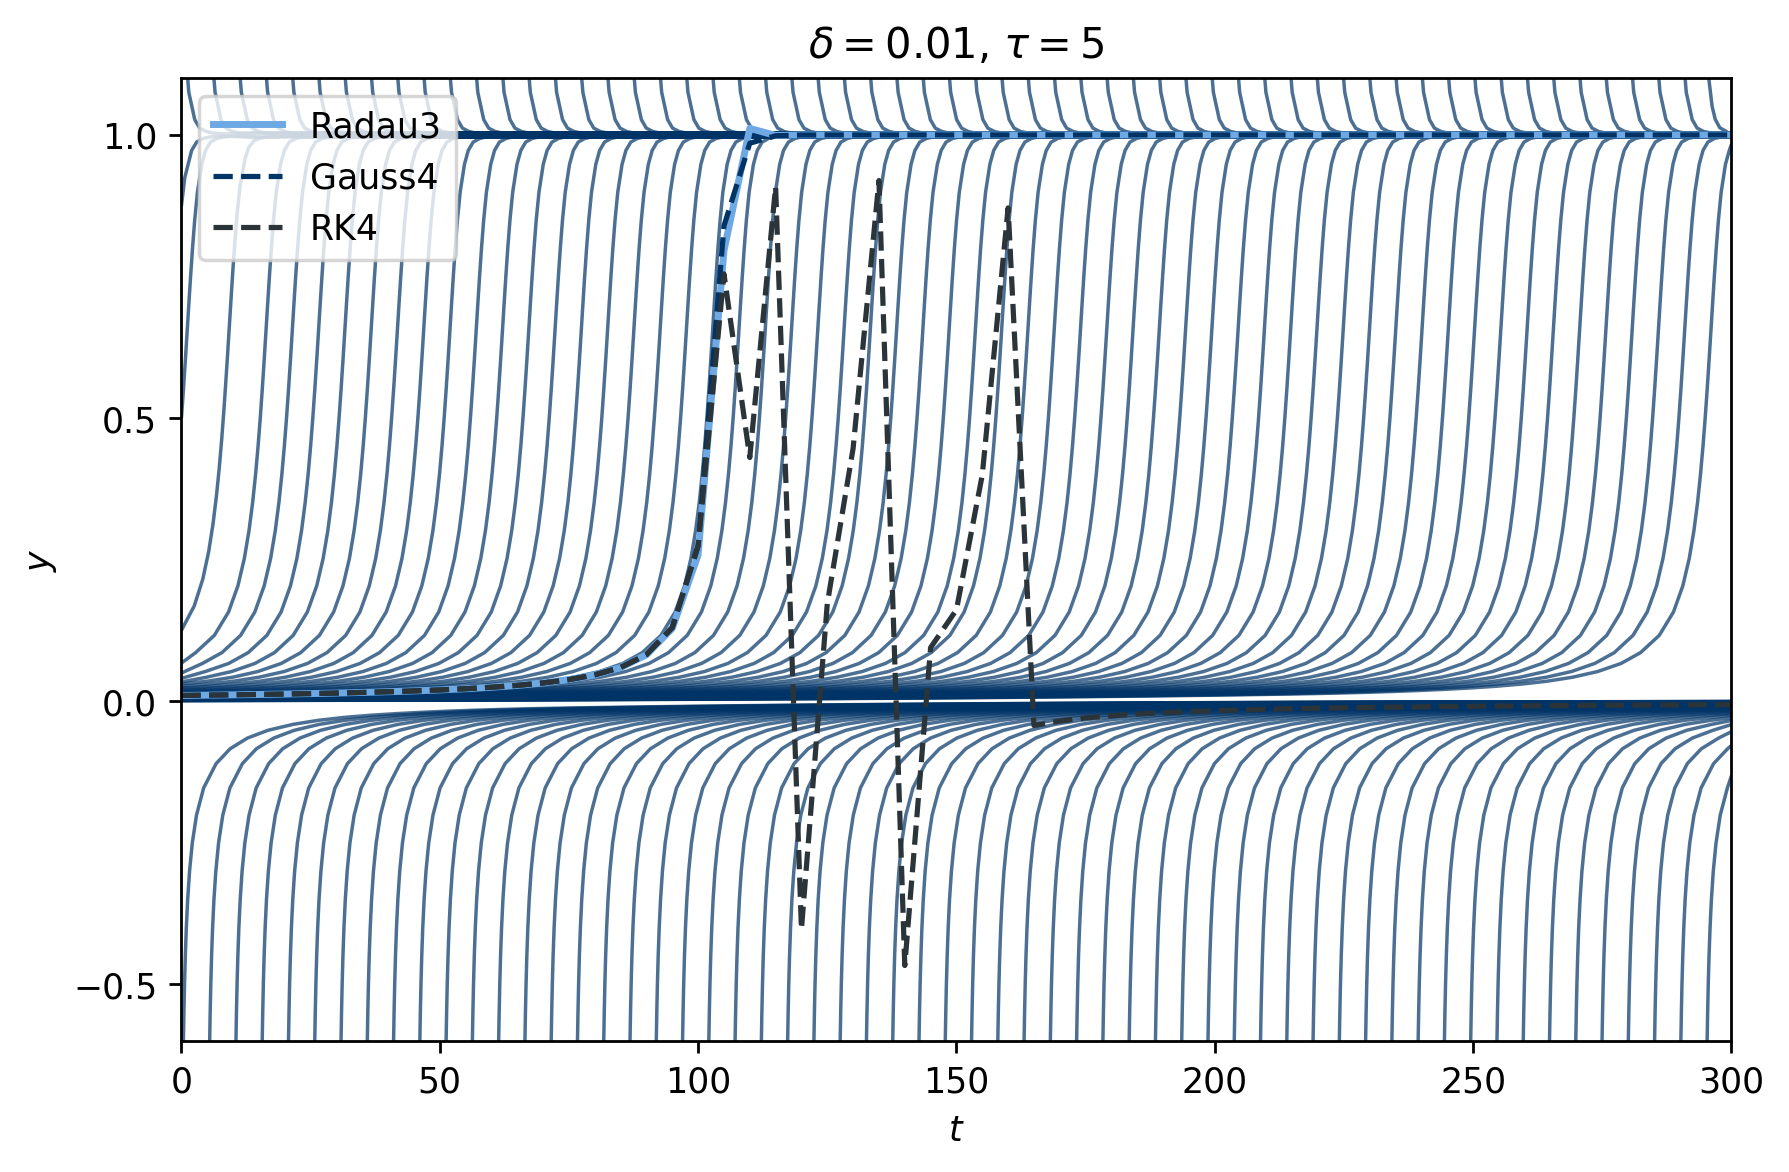

In [229]:
T=300
tau=5
delta=0.01
tg, yg, ktg, kyg = gauss_legendre2(langgomb,np.array([delta]),(0,T),tau)
tr, yr, ktr, kyr = radau2(langgomb,np.array([delta]),(0,T),tau)

lepszam=int(np.ceil(T/tau))+1
t_ertekek=np.array([i*tau for i in range(lepszam)])
yRK=np.zeros(lepszam)
yRK[0]=delta
for i in range(1,lepszam):
    yRK[i]=RK4(yRK[i-1],langgomb_RK4,tau)
fig, ax = plt.subplots(figsize=(8,5), dpi=250)
strm=ax.streamplot(Tt, Y, x1, x2, color="#003366", linewidth=1, density=[2, 0.3], broken_streamlines=False, arrowsize=0)
strm.lines.set_alpha(0.7)
plt.plot(tr, yr, linewidth=2, color="#6EA9E3", label="Radau3")
plt.plot(tg, yg, "--", color="#003366", label="Gauss4", zorder=2)
plt.plot(t_ertekek, yRK, "--", color="#2A3439", label="RK4")
plt.ylim(0.999,1.001)
plt.ylim(-0.6,1.1)
plt.yticks([-0.5,0,0.5,1])
plt.legend()
plt.xlabel(r"$t$")
plt.ylabel(r"$y$")
plt.title(r"$\delta=$"+f"{delta}, "+r"$\tau=$"+f"{tau}")
plt.show()


C:\Users\temes\AppData\Local\Temp\ipykernel_10860\2917933397.py:40: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  K_sol=fsolve(F, K0).reshape(2, -1)


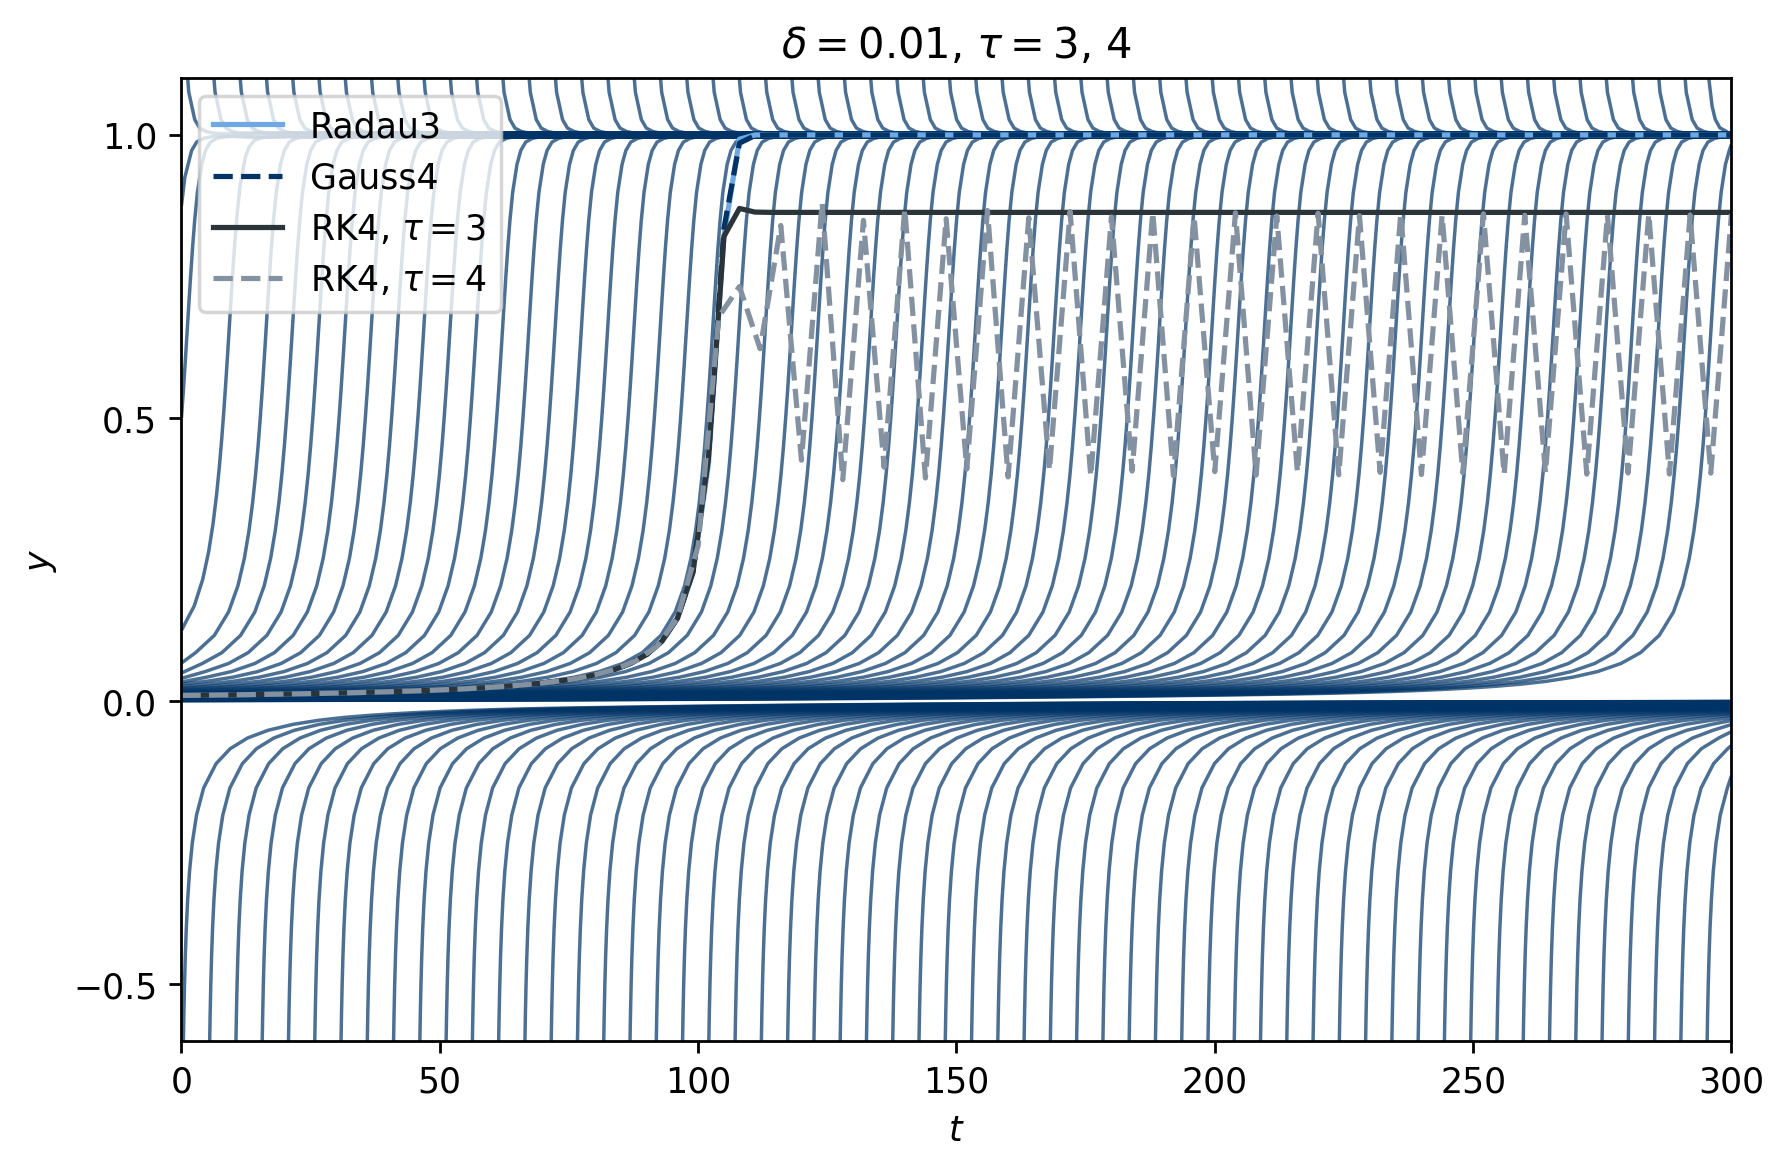

In [230]:
T=300
tau=[3, 4]
delta=0.01
tg, yg, ktg, kyg = gauss_legendre2(langgomb,np.array([delta]),(0,T),tau[0])
tr, yr, ktr, kyr = radau2(langgomb,np.array([delta]),(0,T),tau[0])

lepszam=[int(np.ceil(T/tau[0]))+1, int(np.ceil(T/tau[1]))+1]
t_ertekek=[np.array([i*tau[0] for i in range(lepszam[0])]), np.array([i*tau[1] for i in range(lepszam[1])])]
yRK=[np.zeros(lepszam[0]), np.zeros(lepszam[1])]
yRK[0][0], yRK[1][0] = delta, delta
for i in range(1,lepszam[0]):
    yRK[0][i]=RK4(yRK[0][i-1],langgomb_RK4,tau[0])
for i in range(1,lepszam[1]):
    yRK[1][i]=RK4(yRK[1][i-1],langgomb_RK4,tau[1])
fig, ax = plt.subplots(figsize=(8,5), dpi=250)
strm=ax.streamplot(Tt, Y, x1, x2, color="#003366", linewidth=1, density=[2, 0.3], broken_streamlines=False, arrowsize=0)
strm.lines.set_alpha(0.7)
plt.plot(tr, yr, color="#6EA9E3", label="Radau3")
plt.plot(tg, yg, "--", color="#003366", label="Gauss4", zorder=2)
plt.plot(t_ertekek[0], yRK[0], color="#2A3439", label="RK4, "+r"$\tau=$"+f"{tau[0]}")
plt.plot(t_ertekek[1], yRK[1], "--", color="#8391A1", label="RK4, "+r"$\tau=$"+f"{tau[1]}")
plt.ylim(0.999,1.001)
plt.ylim(-0.6,1.1)
plt.yticks([-0.5,0,0.5,1])
plt.legend()
plt.xlabel(r"$t$")
plt.ylabel(r"$y$")
plt.title(r"$\delta=$"+f"{delta}, "+r"$\tau=$"+f"{tau[0]}, {tau[1]}")
plt.show()


## 4. példa: Lambert

\begin{equation*}
\begin{aligned}
x'(t)&=-2x(t)+y(t)+2\sin t \\
y'(t)&=998x(t)-999y(t)+999(\cos t-\sin t)
\end{aligned}
\end{equation*}

In [3]:
def lambert(t,y):
    xdot=-2*y[0]+y[1]+2*np.sin(t) 
    ydot=998*y[0]-999*y[1]+999*(np.cos(t)-np.sin(t))
    return np.array([xdot, ydot])

def lambert_pontos(t):
    return np.array([-1/999*np.e**(-t)+1/999*np.e**(-1000*t)+np.sin(t), -1/999*np.e**(-t)-998/999*np.e**(-1000*t)+np.cos(t)])

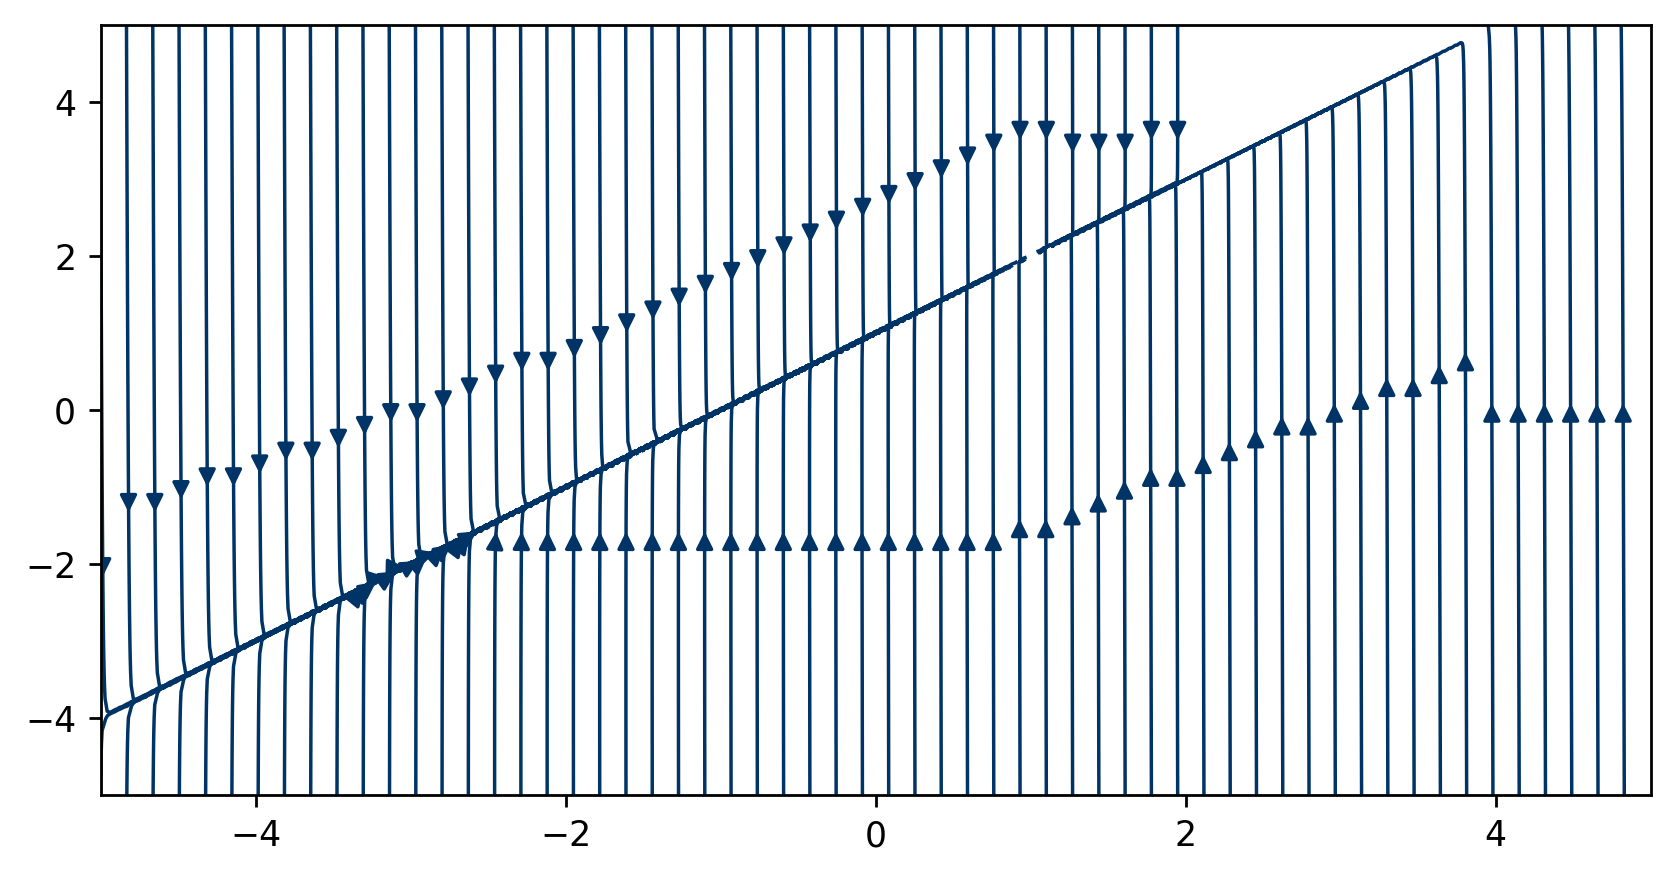

In [12]:
x_max=5
y_max=2
x = np.linspace(-x_max, x_max, 250)
y = np.linspace(-x_max, x_max, 250)
X, Y = np.meshgrid(x, y)

t=0

x1 = -2*X+Y+2*np.sin(t)
x2 = 998*X-999*Y+999*(np.cos(t)-np.sin(t))

fig, ax = plt.subplots(figsize=(8,4), dpi=250)
plt.streamplot(X,Y,x1,x2, color="#003366", linewidth=1, density=[2, 0.3], broken_streamlines=False, arrowsize=1)

plt.show()


In [93]:
T=10
tau=0.1

t_imt, y_imt = imp_trapez(lambert, np.array([0,0]),(0,T),tau)
t_ime, y_ime = imp_euler(lambert, np.array([0,0]),(0,T),tau)
t_g4, y_g4, tk_g4, yk_g4= gauss_legendre2(lambert, np.array([0,0]),(0,T),tau)

t=np.linspace(0,T,1000)

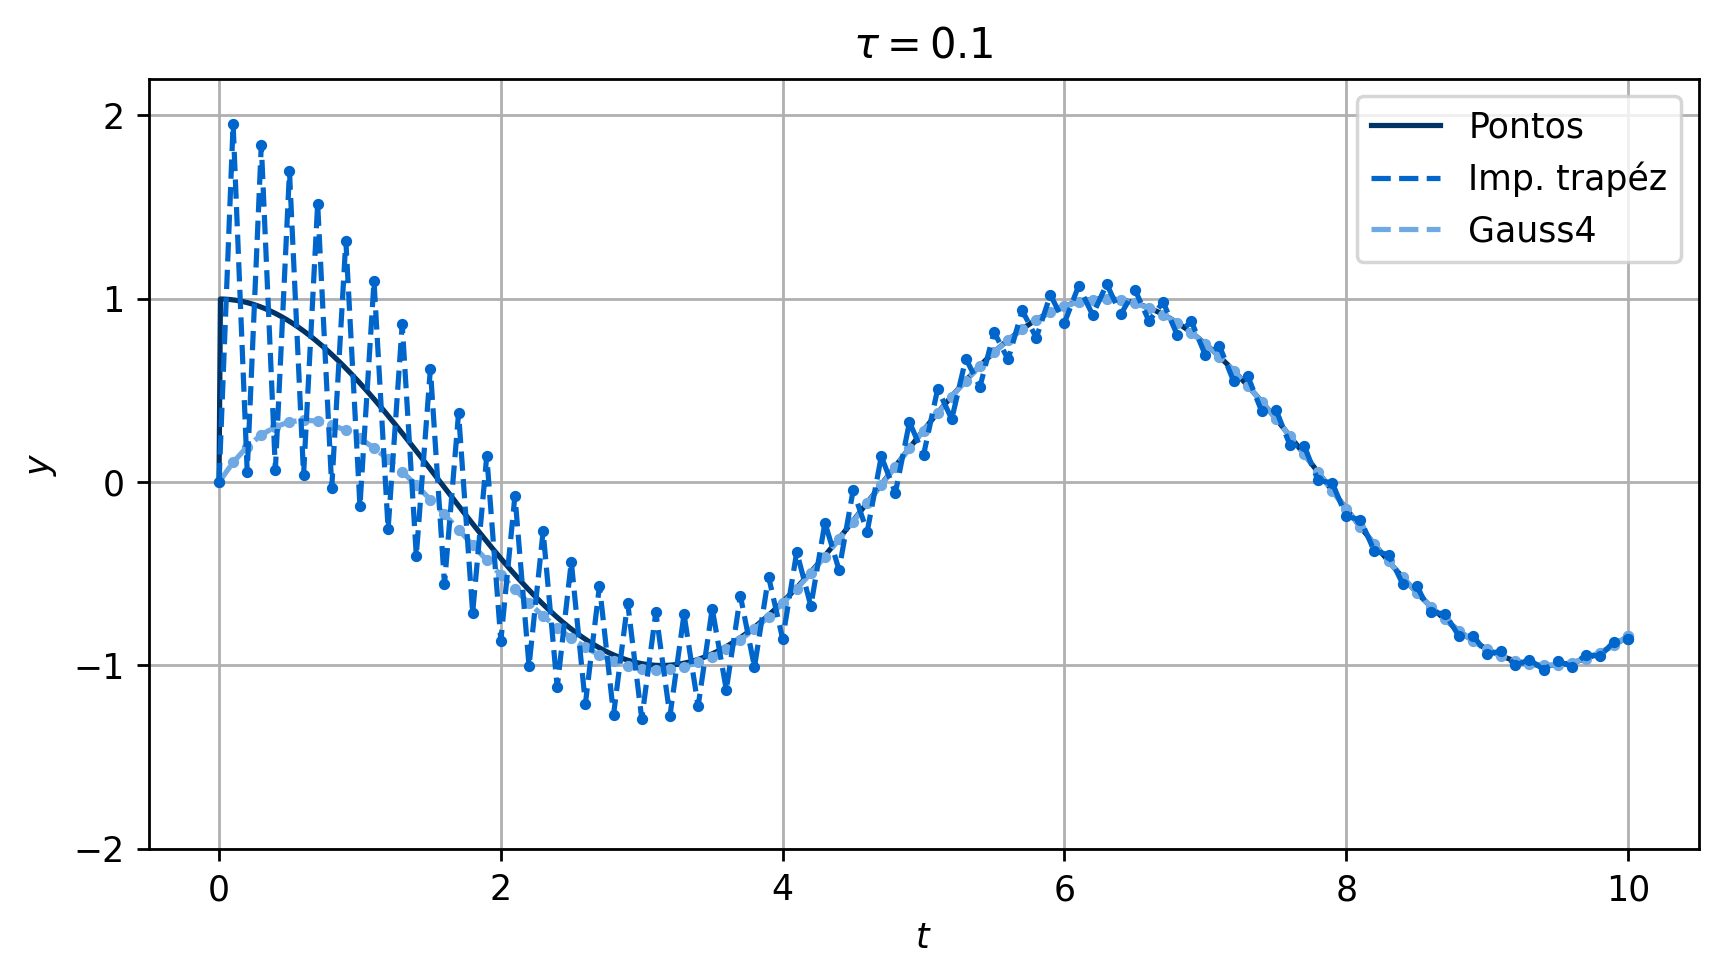

In [94]:
fig, ax = plt.subplots(figsize=(8,4), dpi=250)

plt.title(r"$\tau=$"+f"{tau}")
plt.plot(t, lambert_pontos(t)[1,:], color="#003366", label=f"Pontos")
plt.plot(t_imt, y_imt[:,1], color="#0066CC", linestyle="--", label=f"Imp. trapéz", zorder=3)
plt.plot(t_g4, y_g4[:,1], color="#6EA9E3", linestyle="--", label=f"Gauss4", zorder=2)
plt.scatter(t_imt, y_imt[:,1], color="#0066CC", s=5, zorder=3)
plt.scatter(t_g4, y_g4[:,1], color="#6EA9E3", s=5, zorder=2)
plt.legend()
plt.yticks([-2+i for i in range(5)])
plt.xlabel(r"$t$")
plt.ylabel(r"$y$")
plt.ylim([-2,2.2])
plt.grid()
plt.show()


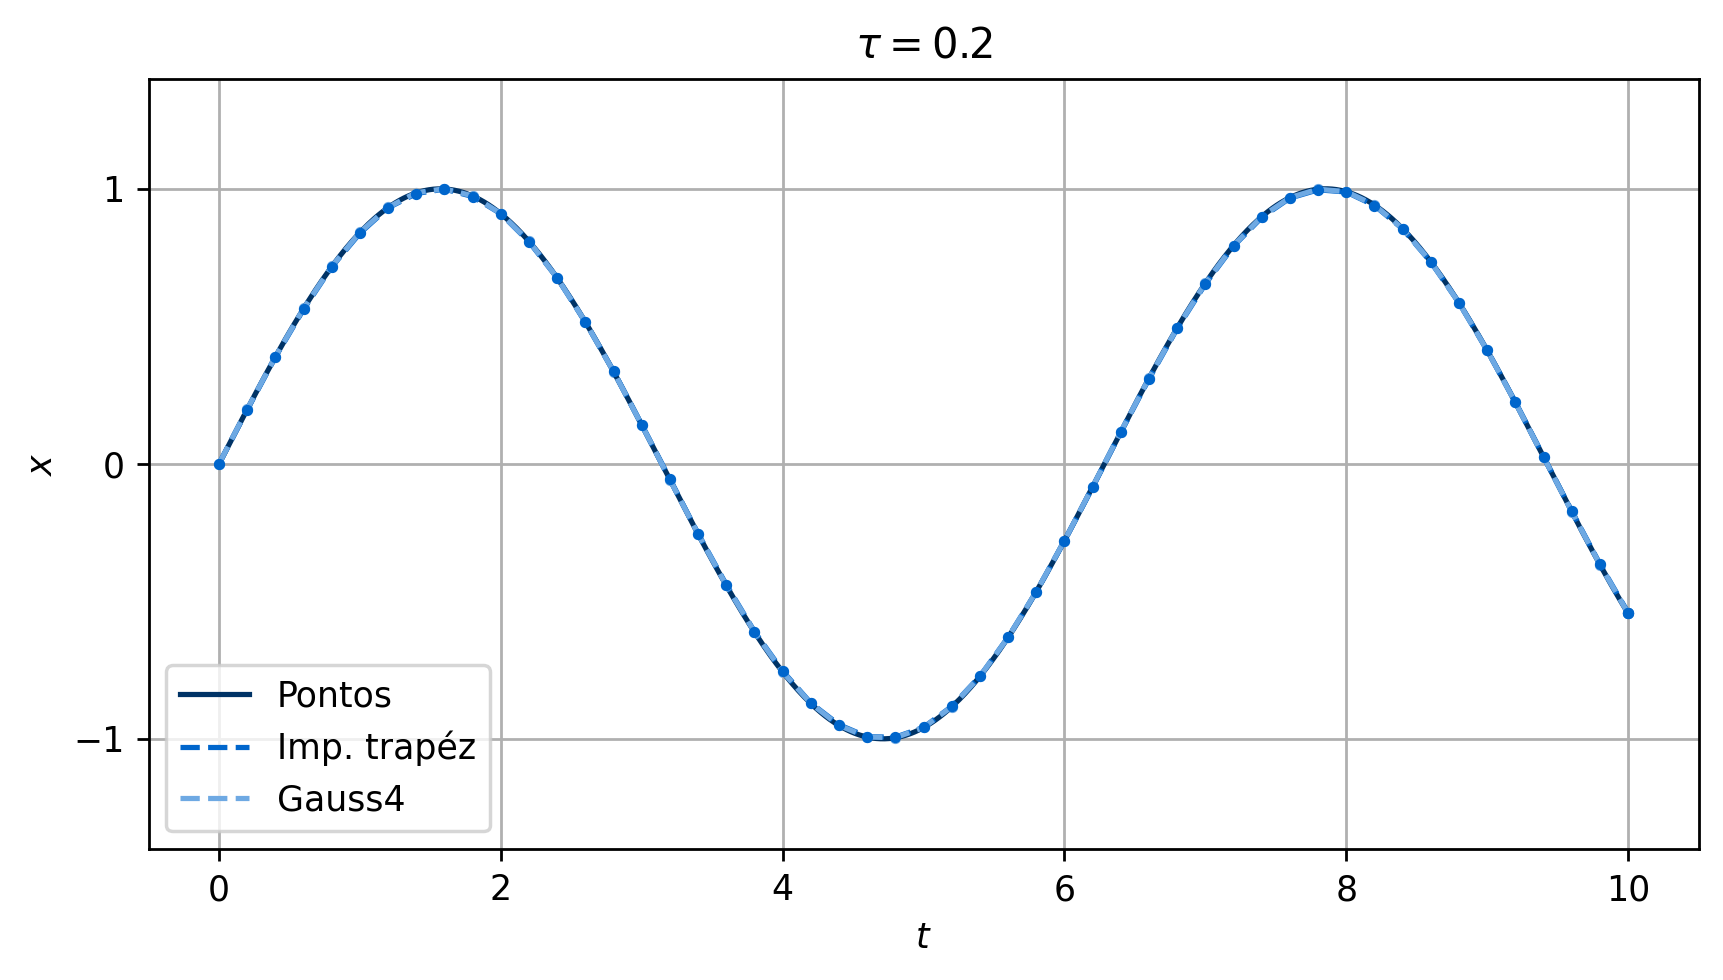

In [89]:
fig, ax = plt.subplots(figsize=(8,4), dpi=250)

plt.title(r"$\tau=$"+f"{tau}")
plt.plot(t, lambert_pontos(t)[0,:], color="#003366", label=f"Pontos")
plt.plot(t_imt, y_imt[:,0], color="#0066CC", linestyle="--", label=f"Imp. trapéz", zorder=2)
plt.plot(t_g4, y_g4[:,0], color="#6EA9E3", linestyle="--", label=f"Gauss4")
plt.scatter(t_imt, y_imt[:,0], color="#0066CC", s=5, zorder=2)
plt.scatter(t_g4, y_g4[:,0], color="#6EA9E3", s=5)
plt.legend()
plt.yticks([-1+i for i in range(4)])
plt.ylim([-1.4,1.4])
plt.xlabel(r"$t$")
plt.ylabel(r"$x$")
plt.grid()
plt.show()

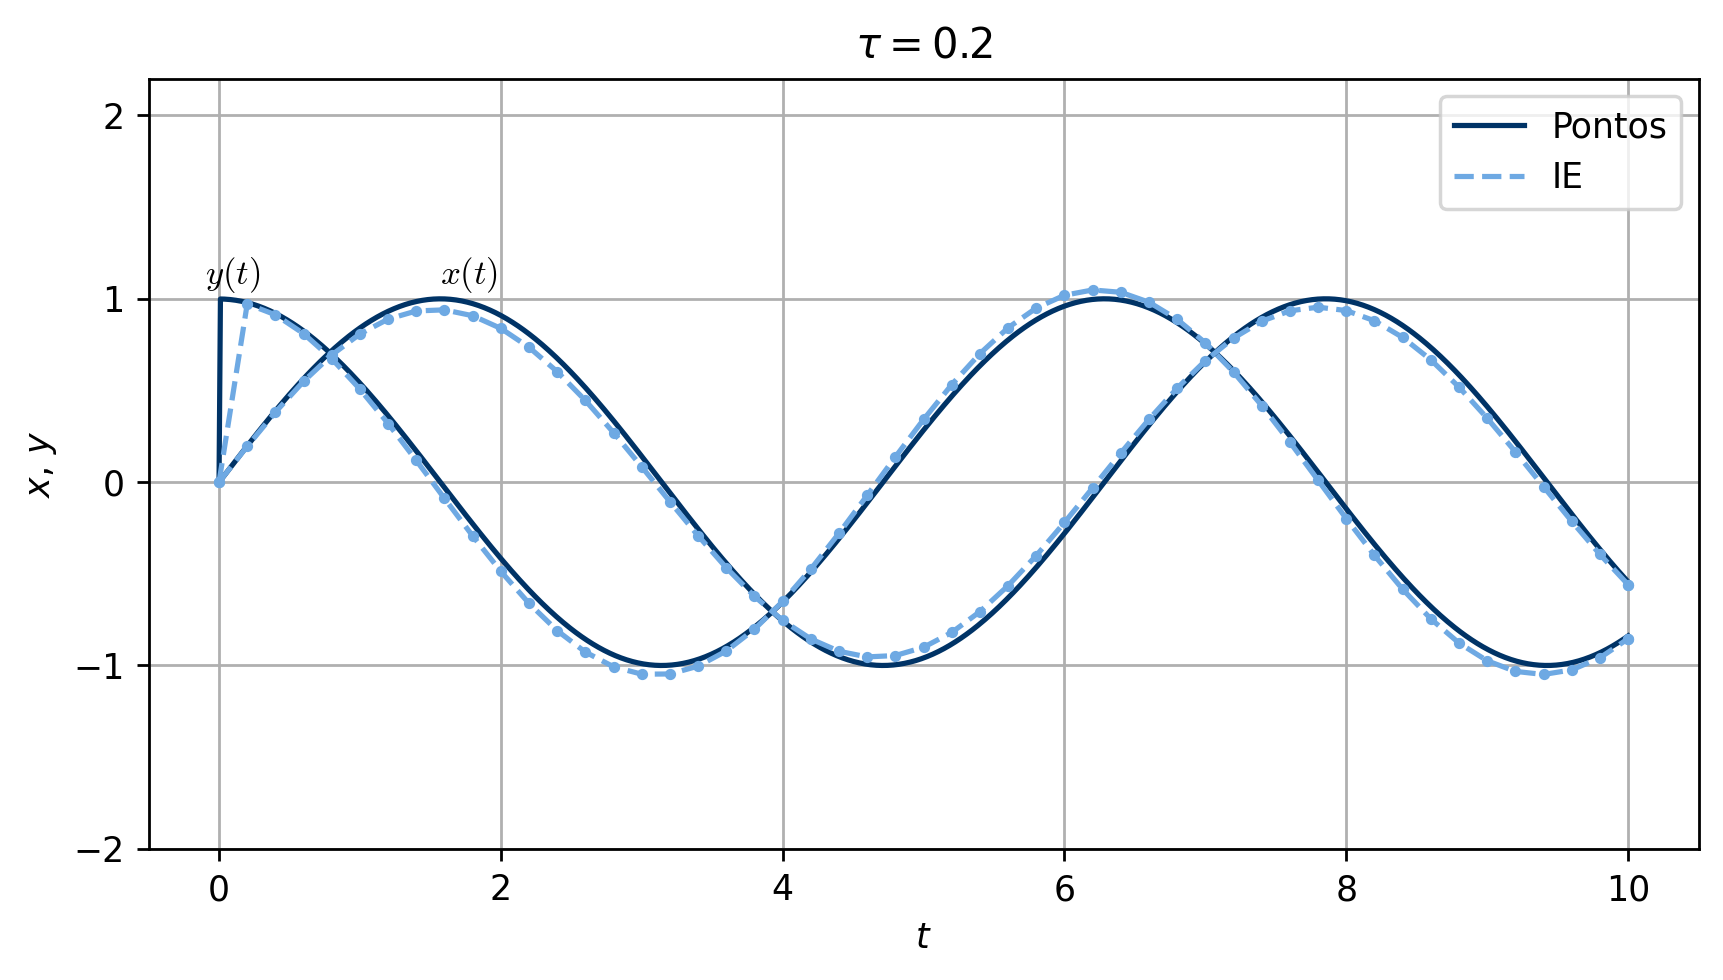

In [4]:
T=10
tau=0.2
t_ime, y_ime = imp_euler(lambert, np.array([0,0]),(0,T),tau)
t=np.linspace(0,T,1000)

fig, ax = plt.subplots(figsize=(8,4), dpi=250)

plt.title(r"$\tau=$"+f"{tau}")
plt.plot(t, lambert_pontos(t)[0,:], color="#003366", label=f"Pontos")
plt.plot(t, lambert_pontos(t)[1,:], color="#003366")
plt.plot(t_ime, y_ime[:,0], color="#6EA9E3", linestyle="--", label=f"IE", zorder=2)
plt.plot(t_ime, y_ime[:,1], color="#6EA9E3", linestyle="--")
plt.scatter(t_ime, y_ime[:,0], color="#6EA9E3", s=5, zorder=2)
plt.scatter(t_ime, y_ime[:,1], color="#6EA9E3", s=5, zorder=2)
plt.legend()
plt.yticks([-2+i for i in range(5)])
plt.xlabel(r"$t$")
plt.ylabel(r"$x, \, y$")
plt.ylim([-2,2.2])
with plt.rc_context({'mathtext.fontset': 'cm'}):
    plt.text(-0.1,1.08,r"$y(t)$")
    plt.text(np.pi/2,1.08,r"$x(t)$")
plt.grid()
plt.show()


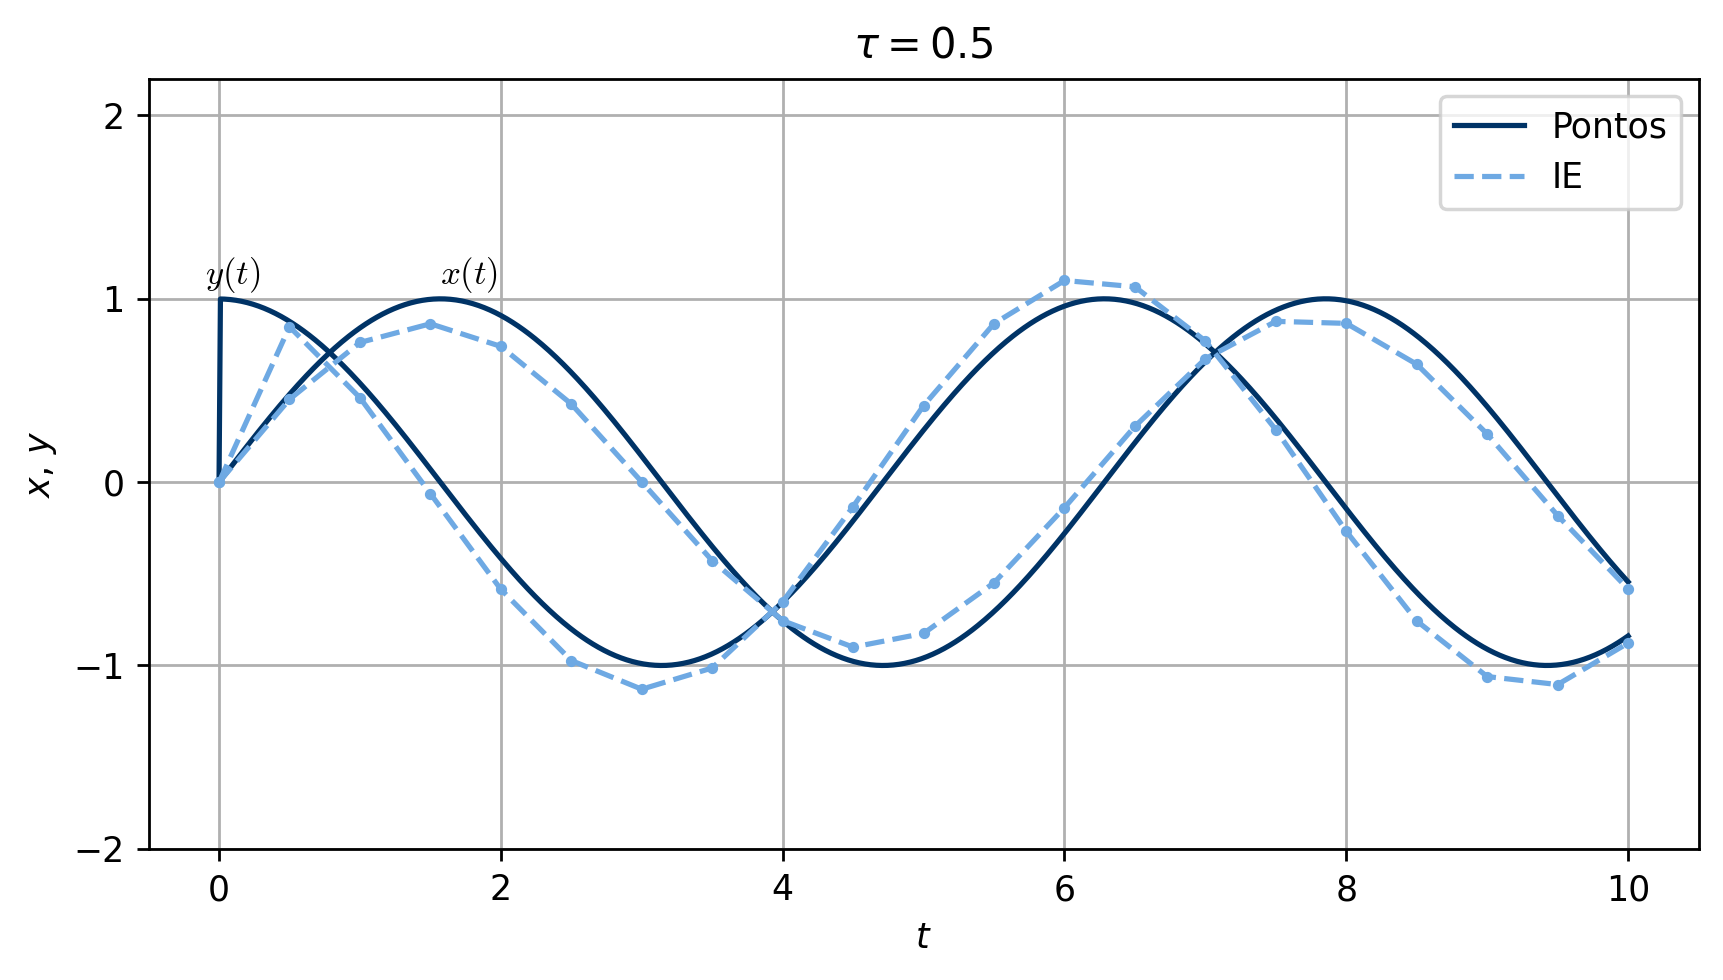

In [7]:
T=10
tau=0.5
t_ime, y_ime = imp_euler(lambert, np.array([0,0]),(0,T),tau)
t=np.linspace(0,T,1000)

fig, ax = plt.subplots(figsize=(8,4), dpi=250)

plt.title(r"$\tau=$"+f"{tau}")
plt.plot(t, lambert_pontos(t)[0,:], color="#003366", label=f"Pontos")
plt.plot(t, lambert_pontos(t)[1,:], color="#003366")
plt.plot(t_ime, y_ime[:,0], color="#6EA9E3", linestyle="--", label=f"IE", zorder=2)
plt.plot(t_ime, y_ime[:,1], color="#6EA9E3", linestyle="--")
plt.scatter(t_ime, y_ime[:,0], color="#6EA9E3", s=5, zorder=2)
plt.scatter(t_ime, y_ime[:,1], color="#6EA9E3", s=5, zorder=2)
plt.legend()
plt.yticks([-2+i for i in range(5)])
plt.xlabel(r"$t$")
plt.ylabel(r"$x, \, y$")
plt.ylim([-2,2.2])
with plt.rc_context({'mathtext.fontset': 'cm'}):
    plt.text(-0.1,1.08,r"$y(t)$")
    plt.text(np.pi/2,1.08,r"$x(t)$")
plt.grid()
plt.show()